# Udacity Data Science Nanodegree 
## Capstone Project: Starbucks
Sandra Muschkorgel
Berlin, 27th June 2021

## Content
* <a href="#intro">Introduction</a>
* <a href="#assess">Data Assessment and Cleaning</a>
* <a href="#explore">Exploratory Data Analysis</a>
* <a href="#preprocess">Preprocessing</a>
* <a href="#model">Modeling and Evaluation</a>
  * <a href="#model1">Model 1 - Classifier Model</a>
  * <a href="#model2">Model 2 - Collaborative Filtering Recommendation System</a>
  * <a href="#model3">Model 3 - Ranked Based Recommendation System</a>
* <a href="#evaluate">Model Refinement</a>
* <a href="#end">Conclusion</a>

***

<a id="intro"></a>
## Introduction

* Goal: Identify which offer to send to which user
* Money spent on advertising and/or rewards vs return 
* Users are part of a Starbucks loyalty program

**Data**
* Three datasets:
  * profile.json is a user database storing information about age, gender, income and the date on which a user became a member.
  * portfolio.json lists all offers a user might have received detailing the sort of offer, the offer period, the reward associated with it, the channels which were used to sent the offer to users and the offer difficulty, i.e. the upfront investment a user has to make to receive a reward.
  * transcript.json contains event data over a period of two years in which the following events were logged: receiving an offer, viewing an offer, completing an offer and spending x amount on a purchase which might or might not be connected to an offer.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
# Load datasets from json files
profile = pd.read_json('data/profile.json', lines=True)
portfolio = pd.read_json('data/portfolio.json', lines=True)
transcript = pd.read_json('data/transcript.json', lines=True)

***
<a id="assess"></a>
## Data Assessment and Cleaning

In this section I will visually and programmatically analyze all three dataframes focusing on data quality and tidiness issues. Based on these findings I will clean the dataframes accordingly.

**`profile`**

In [3]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


**Dataframe columns**
* *gender* 
  * F - female
  * M - male
  * O - Other
  * None - missing value
* *age* (118 identifies missing values)
* *id* hashed user id
* *became_member_on* date on which a user became a member
* *income* 

In [4]:
profile.shape

(17000, 5)

In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [6]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
profile.nunique()

gender                  3
age                    85
id                  17000
became_member_on     1716
income                 91
dtype: int64

In [8]:
profile.isnull().sum()['gender'] / profile.shape[0]

0.12794117647058822

Every user only appears once in the dataset. However, 13% of users have no entries for age, gender and income.

In [9]:
profile[profile.age == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [10]:
profile[profile.age < 118].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [11]:
profile[(profile.age > 80) & (profile.age < 118)]['income'].describe()

count       986.000000
mean      71787.018256
std       22318.990431
min       30000.000000
25%       55000.000000
50%       71000.000000
75%       88750.000000
max      120000.000000
Name: income, dtype: float64

In [12]:
profile.duplicated().sum()

0

In [13]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

**`portfolio`**

In [14]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Dateframe columns**
* *reward* money received for buying an offer
* *channels* list of communication channels which were used to send out an offer
* *difficulty* upfront investment a user has to make to receive a reward 
* *duration* offer period
* *offer_type* 
  * bogo - buy one get one free
  * discount
  * informational offer
* *id* hashed offer id

In [15]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


**`transcript`** 

In [16]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


**Dataframe columns**
* *person* hashed user id
* columns *event* and *value* (The second of which is a dictionary.)
  * offer received | {'offer id': 'hashed offer id'}
  * offer viewed | {'offer id': 'hashed offer id'}
  * offer completed | {'offer_id': 'hashed offer id'} &rarr; This event is only logged for a user if he/she received a reward, i.e. completed an offer successfully.
  * transaction | {'amount': money spent in transaction} &rarr; This event is logged for the amount of money a user spent regardless whether it was related to an offer or not.
* *time* in days, continuous count from
  * 0 (start of the observation period)
  * to 714 (end of the observation period)

In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
# Events for a randomly selected user
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [19]:
transcript[transcript.event == 'offer received'].sample(5)

,person,event,value,time
247599,afe96b883fa846e9a972b73f8de5812f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},576
254122,0d069e0def304114b261daa9695433ba,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576
57839,da37f5aae7834a9aa6eb19a3e4ce776a,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168
250692,233135b25fbe42b6afc24081d9caf06a,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},576
936,83d25e2f43e1468eae4fc9111b61a9df,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [20]:
transcript[transcript.event == 'offer viewed'].sample(5)

,person,event,value,time
274784,e973d133f6c547439dac45482d096241,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},606
166758,57835e26d1a7491b9974b15583758a2b,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408
173874,5a37cb8ebd134bd8b6d1b45024e106d5,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},420
17488,75c1b4d22fd24b35b2f0a52fd8ff1735,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},6
190094,adb5fffb5e674fd4afc400ea893e171c,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},462


In [21]:
transcript[transcript.event == 'transaction'].sample(5)

,person,event,value,time
86556,5180d955d076408dac0e7a3004756889,transaction,{'amount': 5.38},216
282519,ea9fa7fbbcdc44d79b0f0d62d5bbbc41,transaction,{'amount': 7.8100000000000005},624
184171,589b798b4cfd4429b42f139490f97708,transaction,{'amount': 6.13},444
47131,2f7a17a522474ba7ab3acf8c0bad2c62,transaction,{'amount': 16.9},126
303283,3a1747f3e741449387bb614da8e0171c,transaction,{'amount': 22.38},702


In [22]:
transcript[transcript.event == 'offer completed'].sample(5).value.values

array([{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10},
       {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5},
       {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10},
       {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}],
      dtype=object)

In [23]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Since there are missing entries in the ``profile`` dataframe, I will check whether transactions for these users exist.

In [24]:
incomplete_profiles = profile[profile.gender.isnull()]['id'].values
transcript_profiles = transcript.person.values

In [25]:
len(incomplete_profiles), len(np.intersect1d(incomplete_profiles, transcript_profiles))

(2175, 2175)

All users with incomplete records can be found in the ``transcript`` dataframe, i.e. have at least one event attached to them.
 
### Assessment summary

#### Data quality
`profile`
* Age 118 encodes missing values
* 2,175 missing entries in *gender*, *age* and *income* column
* Erronuous data type: *became_member_on* int64 &rarr; datetime
  
`portfolio`
* *channels* combined in one column
* Erronuous data type: *offer_type* object &rarr; categorical

`transcript`
* Different keys in *value* column describing the same: offer id and offer_id
* Event 'offer completed' has dictionary with two keys: offer_id and reward

#### Tidiness
* `transcript` *value* column holds dictionaries 

### Data Cleaning

In [26]:
# Create copies for cleaned dataframes
profile_clean = profile.copy()
portfolio_clean = portfolio.copy()
transcript_clean = transcript.copy()

Before cleaning up each dataframe I will map the hashed user and offer ids to more readable versions.

In [27]:
def id_mapping(df, col):
    """
    Map hashed ids to more readable version.
    
    INPUT:
    df - dataframe 
    col - column containing the hashed ids
    
    OUTPUT:
    encoded - list containing the shortened ids
    mapping - dict containing all id pairs 
              key: hashed id (original), value: encoded id
    """
    
    mapping = {}
    counter = 1
    encoded = []
    
    for val in df[col]:
        if val not in mapping:
            mapping[val] = counter
            counter += 1
        
        encoded.append(mapping[val])
    return encoded, mapping

In [28]:
# Map person id in profile_clean
encoded_profile, mapping_profile = id_mapping(profile_clean, 'id')
profile_clean['person_id'] = encoded_profile

profile_clean.head()

,gender,age,id,became_member_on,income,person_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5


Since the *id* column is no longer required, I will drop it.

In [29]:
profile_clean.drop('id', axis=1, inplace=True)

In [30]:
# Map offer id in portfolio_clean
encoded_portfolio, mapping_portfolio = id_mapping(portfolio_clean, 'id')
portfolio_clean['offer_id'] = encoded_portfolio

portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,8
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,9
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,10


Since the *id* column is no longer required, I will drop it.

In [31]:
portfolio_clean.drop('id', axis=1, inplace=True)

In [32]:
# Map person id in transcript_clean
encoded_person = []
for val in transcript_clean['person']:
    encoded_person.append(mapping_profile[val])
    
transcript_clean['person_id'] = encoded_person
transcript_clean.drop('person', axis=1, inplace=True)
transcript_clean.head(10)

,event,value,time,person_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,4
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,5
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,6
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,7
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,8
5,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,9
6,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,11
7,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,13
8,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,14
9,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,16


We cannot map the *value* column offer ids directly since they are stored as part of a dictionary. First, I need to transform the entire column. Then I will be able to extract the ids and map the offer ids to their corresponding encoded ids.

**`profile_clean`**

#### Erronuous data type

##### Define
Transform data type: *became_member_on* int64 &rarr; datetime.

##### Code

In [33]:
profile_clean.became_member_on = profile_clean.became_member_on.astype(str)
profile_clean['member_year'] = profile_clean.became_member_on.str.slice(0, 4).astype(int)
profile_clean['member_month'] = profile_clean.became_member_on.str.slice(4, 6).astype(int)
profile_clean['member_day'] = profile_clean.became_member_on.str.slice(6, 8).astype(int)

In [34]:
# Drop became_member_on column
profile_clean.drop('became_member_on', axis=1, inplace=True)

##### Test

In [35]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        14825 non-null  object 
 1   age           17000 non-null  int64  
 2   income        14825 non-null  float64
 3   person_id     17000 non-null  int64  
 4   member_year   17000 non-null  int64  
 5   member_month  17000 non-null  int64  
 6   member_day    17000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 929.8+ KB


In [36]:
profile_clean.head()

,gender,age,income,person_id,member_year,member_month,member_day
0,None,118,NaN,1,2017,2,12
1,F,55,112000.0,2,2017,7,15
2,None,118,NaN,3,2018,7,12
3,F,75,100000.0,4,2017,5,9
4,None,118,NaN,5,2017,8,4


#### Missing values
* Age 118 encodes missing values
* 2,175 missing entries in *gender*, *age* and *income* column

##### Define
I will build models for users with and without missing values which is why I will split ``profile_clean`` into two dataframes:
* ``profile_complete`` (see <a href="#model1">Model 1</a>)
* ``profile_incomplete`` (see <a href="#model2">Model 2</a>)

For ``profile_incomplete`` I will replace the age 118 with actual NaNs to avoid future misinterpretation.

##### Code

In [37]:
profile_complete = profile_clean.drop(profile_clean[profile_clean.gender.isnull()].index)
profile_incomplete = profile_clean.drop(profile_clean[profile_clean.gender.notnull()].index)

In [38]:
profile_incomplete['age'] = np.nan

##### Test

In [39]:
profile_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        14825 non-null  object 
 1   age           14825 non-null  int64  
 2   income        14825 non-null  float64
 3   person_id     14825 non-null  int64  
 4   member_year   14825 non-null  int64  
 5   member_month  14825 non-null  int64  
 6   member_day    14825 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 926.6+ KB


In [40]:
profile_incomplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        0 non-null      object 
 1   age           0 non-null      float64
 2   income        0 non-null      float64
 3   person_id     2175 non-null   int64  
 4   member_year   2175 non-null   int64  
 5   member_month  2175 non-null   int64  
 6   member_day    2175 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 135.9+ KB


**`portfolio_clean`**

#### *channels* combined in one column

##### Define 
Split *channels* into separate columns each representing one particular communication channel. Use 1 and 0 to indicate whether a channel was used for an offer or not.

##### Code

In [41]:
for i, val in enumerate(portfolio_clean['channels']):
    for channel in val:
        portfolio_clean.loc[i, channel] = 1

In [42]:
portfolio_clean.fillna(0, inplace=True)

In [43]:
for col in ['email', 'mobile', 'social', 'web']:
    portfolio_clean[col] = portfolio_clean[col].astype(int)

##### Test

In [44]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,1,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,2,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,4,1,1,0,1
4,5,"[web, email]",20,10,discount,5,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,6,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,7,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,8,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,9,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,10,1,1,0,1


In [45]:
# Drop channels column
portfolio_clean.drop('channels', axis=1, inplace=True)

#### Erronuous data type

##### Define
Transform data type: *offer_type* object &rarr; categorical.

##### Code

In [46]:
portfolio_clean['offer_type'] = portfolio_clean['offer_type'].astype('category')

##### Test

In [47]:
portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   reward      10 non-null     int64   
 1   difficulty  10 non-null     int64   
 2   duration    10 non-null     int64   
 3   offer_type  10 non-null     category
 4   offer_id    10 non-null     int64   
 5   email       10 non-null     int64   
 6   mobile      10 non-null     int64   
 7   social      10 non-null     int64   
 8   web         10 non-null     int64   
dtypes: category(1), int64(8)
memory usage: 910.0 bytes


**`transcript`**

#### Different keys in *value* column describing the same: offer id and offer_id // Event 'offer completed' has dictionary with two keys: offer_id and reward // Tidiness 
**Note:** All issues can be handled at once.

##### Define
Separate the value column into three columns *offer_id*, *amount* and *reward*.

##### Code

In [48]:
# Extract values from dictionary in value column
tmp = pd.DataFrame(transcript_clean.value.values.tolist())

In [49]:
# Combine offer_id and offer id into one column
tmp.loc[tmp['offer id'].isnull(), 'offer id'] = tmp.loc[tmp['offer id'].isnull(), 'offer_id'].values
tmp.drop('offer_id', axis=1, inplace=True)

In [50]:
# Combine transcript_clean with the temporary df
transcript_clean = pd.concat([transcript_clean, tmp], axis=1)

In [51]:
# Map offer id to unhashed ids
encoded_offer = []
for val in transcript_clean['offer id']:
    if pd.isna(val):
        encoded_offer.append(np.nan)
    else:
        encoded_offer.append(mapping_portfolio[val])
    
transcript_clean['offer_id'] = encoded_offer
transcript_clean.drop('offer id', axis=1, inplace=True)

In [52]:
# Drop value column since it's no longer required
transcript_clean.drop('value', axis=1, inplace=True)

##### Test

In [53]:
transcript_clean.head(10)

,event,time,person_id,amount,reward,offer_id
0,offer received,0,4,NaN,NaN,4.0
1,offer received,0,5,NaN,NaN,5.0
2,offer received,0,6,NaN,NaN,10.0
3,offer received,0,7,NaN,NaN,7.0
4,offer received,0,8,NaN,NaN,2.0
5,offer received,0,9,NaN,NaN,9.0
6,offer received,0,11,NaN,NaN,6.0
7,offer received,0,13,NaN,NaN,3.0
8,offer received,0,14,NaN,NaN,5.0
9,offer received,0,16,NaN,NaN,5.0


In [54]:
transcript_clean.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

***
<a id="explore"></a>
## Exploratory Data Analysis

For this next part, I will explore each dataframe to gain first insights about the users represented in ``profile`` and their transactions in ``transcript_clean``.

**``profile_complete``**

In [55]:
profile_complete.gender.value_counts() / profile_complete.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

With a share of 57%, men represented the largest user group. 41% were women and only 1% belonged to the category *Other*. 

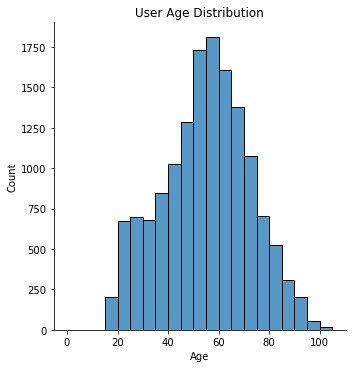

In [56]:
bins = np.arange(0, profile_complete.age.max()+5, 5)
sb.displot(profile_complete.age, bins=bins)
plt.title('User Age Distribution')
plt.xlabel('Age');

The user age roughly followed a normal distribution and was centered around 54 years. The youngest users were 18 years old, the oldest 101.

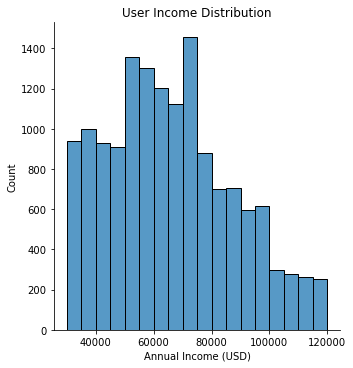

In [57]:
bins = np.arange(30000, profile_complete.income.max()+5000, 5000)
sb.displot(profile_complete.income, bins=bins)
plt.title('User Income Distribution')
plt.xlabel('Annual Income (USD)');

When looking at income buckets of USD 5,000 most users earned between USD 50,000 and USD 75,000. Beyond USD 75,000 annual salary, the number of users per bucket gradually decreased. Another large user group belonged to the low income population earning between USD 30,000 and USD 50,000.

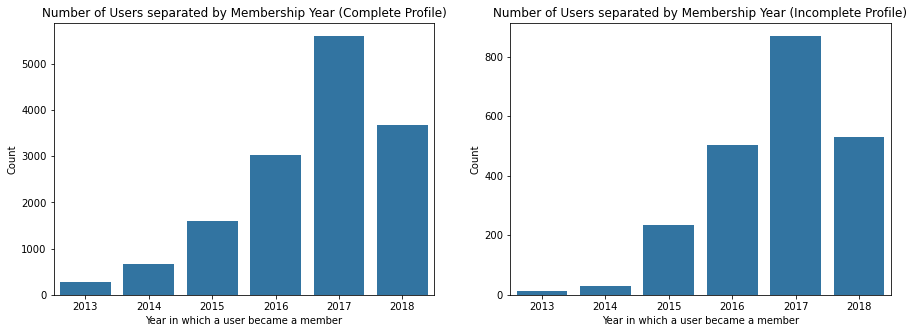

In [58]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sb.countplot(data=profile_complete, x='member_year', color=base_color)
plt.title('Number of Users separated by Membership Year (Complete Profile)')
plt.xlabel('Year in which a user became a member')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sb.countplot(data=profile_incomplete, x='member_year', color=base_color)
plt.title('Number of Users separated by Membership Year (Incomplete Profile)')
plt.xlabel('Year in which a user became a member')
plt.ylabel('Count');

Most users became a Starbucks member in 2017. Between 2013 and 2016 the number of members signing up continuously increased. In 2018 Starbucks experienced a drop in new memberships. This pattern is true for both user groups, with complete and incomplete profiles.

In [59]:
profile_complete.groupby('gender')['age'].mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

Women represented the oldest user group with an average of 57 years. The average male user was 5 years younger and the average other user 54.

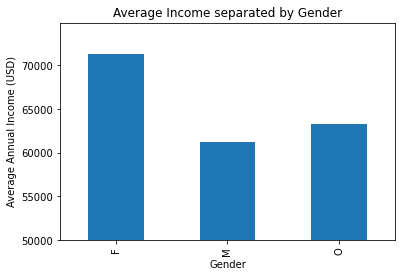

In [60]:
profile_complete.groupby('gender')['income'].mean().plot(kind='bar')
plt.ylim(50000, None)
plt.title('Average Income separated by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Annual Income (USD)');

In [61]:
profile_complete.groupby('gender')['income'].mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

Women earned more than USD 70,000 per year. Men on the other hand earned USD 10,000 less. The other users had an annual income of around USD 63,000.

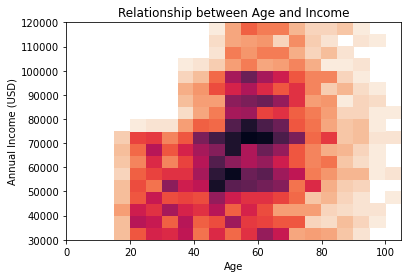

In [62]:
sample_size = 0.3 # If you choose 1 the entire dataset will be displayed
sample = profile_complete.sample(int(sample_size*profile_complete.shape[0]))
x_bins = np.arange(0, sample.age.max()+5, 5)
y_bins = np.arange(30000, sample.income.max()+5000, 5000)
plt.hist2d(x=sample['age'], y=sample['income'], cmin=0.5, cmap='rocket_r', bins=[x_bins, y_bins])
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (USD)');

There is no strong relationship between age and income. Users younger than 35 did not surpass the USD 80,000 salary threshold. Older users (70+ years) displayed incomes across the entire spectrum. There was a large cluster of users between 40 and 70 earning between USD 50,000 and USD 90,000.

**``portfolio_clean``**

In [63]:
portfolio_clean[portfolio_clean.offer_type == 'bogo']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,1,1,1,1,0
1,10,10,5,bogo,2,1,1,1,1
3,5,5,7,bogo,4,1,1,0,1
8,5,5,5,bogo,9,1,1,1,1


In [64]:
portfolio_clean[portfolio_clean.offer_type == 'discount']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
4,5,20,10,discount,5,1,0,0,1
5,3,7,7,discount,6,1,1,1,1
6,2,10,10,discount,7,1,1,1,1
9,2,10,7,discount,10,1,1,0,1


In [65]:
portfolio_clean[portfolio_clean.offer_type == 'informational']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
2,0,0,4,informational,3,1,1,0,1
7,0,0,3,informational,8,1,1,1,0


When looking at each offer type individually the following can be observed:
* All offer types were sent out via email. With the exception of offer 5, which is the one with the highest difficulty, all offers were offered as a mobile version. The social and web channels were used more infrequently.
* Informational offers did not reward users and only lasted for 3 to 4 days.
* Per definition a bogo (= buy one get one free) always returned the same reward as was invested by the user (*difficulty*). They lasted either 5 or 7 days.
* Discount offers lasted either 7 or 10 days while offering lower rewards compared to bogos.
* There were several offer pairs which offered the same reward for the same upfront investment (*difficulty*) but lasted for different time periods: 1 and 2, 4 and 9, 7 and 10 (excluding informational offers).

**``transcript_clean``**

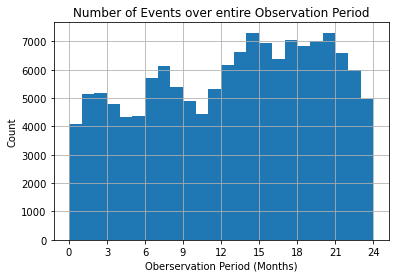

In [66]:
bins = np.arange(0, transcript_clean.time.max()+30, 30) # Monthly period
transcript_clean[transcript_clean.event == 'transaction']['time'].hist(bins=bins)
plt.title('Number of Events over entire Observation Period')
plt.xlabel('Oberservation Period (Months)')
plt.ylabel('Count')
ticks = np.arange(0, transcript_clean.time.max()+30, 90)
labels = ['{}'.format(int(v/30)) for v in ticks]
plt.xticks(ticks, labels);

In [67]:
transcript_clean[transcript_clean.time < 714 / 2]['event'].count() 

135224

In [68]:
transcript_clean[transcript_clean.time >= 714 / 2]['event'].count() 

171310

Events were recorded for a two year period. During the first year 135,224 events took place, compared to 171,310 events during the second year.

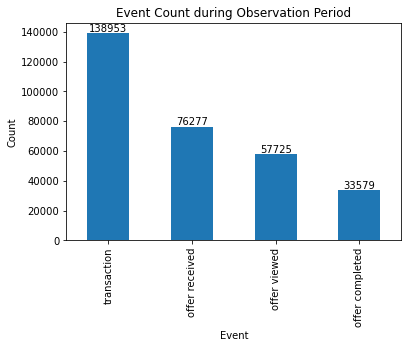

In [69]:
event_count = transcript_clean.event.value_counts()
event_count.plot(kind='bar')
plt.title('Event Count during Observation Period')
plt.xlabel('Event')
plt.ylabel('Count')
for i in np.arange(4):
    plt.text(x=i, y=event_count[i]+1000, s='{}'.format(event_count[i]), ha='center');

In [70]:
event_count[2] / event_count[1], event_count[3] / event_count[1]

(0.7567812053436815, 0.4402244451145168)

In [71]:
event_count[0] / transcript_clean.time.max(), event_count[0] / profile_clean.shape[0]

(194.61204481792717, 8.173705882352941)

During the observation period users spent money on Starbucks products almost 140,000 times. This calculates to a daily rate of 195 transactions and roughly 8 transactions per user for the entire time frame. More than 76,000 offers were sent out, of which 76% were viewed and 44% were completed.

In [72]:
np.log10(transcript_clean.amount.describe())

count    5.142868
mean     1.106441
std      1.480733
min     -1.301030
25%      0.444045
50%      0.948902
75%      1.256958
max      3.026239
Name: amount, dtype: float64

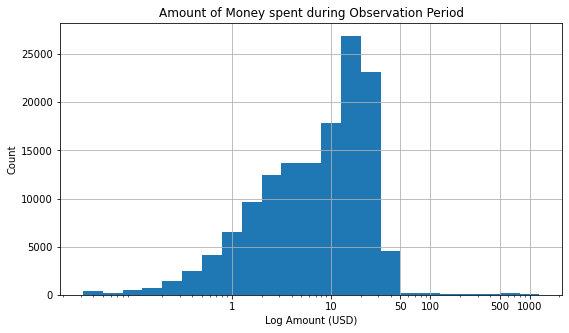

In [73]:
plt.figure(figsize=(9,5))
bins = 10 ** np.arange(-1.5, 3+0.2, 0.2)
transcript_clean[transcript_clean.event == 'transaction']['amount'].hist(bins=bins)

plt.title('Amount of Money spent during Observation Period')
plt.xlabel('Log Amount (USD)')
plt.ylabel('Count')
plt.xscale('log')
ticks = [1, 10, 50, 100, 500, 1000]
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels);

With regards to how much people spent per transaction a logarithmic distribution emerges. Most users spent around USD 10 to USD 25 on a transaction. Only very few users spent more than USD 50. There was a second large user group spending between less than USD 10. 

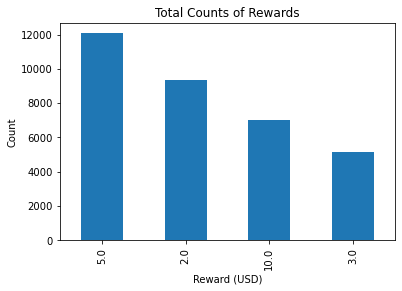

In [74]:
transcript_clean[transcript_clean.reward.notnull()]['reward'].value_counts().plot(kind='bar')
plt.title('Total Counts of Rewards')
plt.xlabel('Reward (USD)')
plt.ylabel('Count');

In terms of absolute numbers the USD 5 reward was handed out most of the time, followed by USD 2, USD 10 and finally USD 3 rewards (in descending order).

In [75]:
offers_sent = transcript_clean[transcript_clean.event == 'offer received']['offer_id'].value_counts()
rewards = transcript_clean[transcript_clean.reward.notnull()]['offer_id'].value_counts() / offers_sent

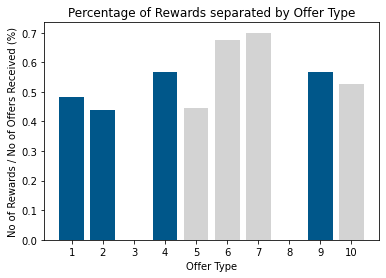

In [76]:
plt.bar(rewards.index, rewards.values, color=['#00578a', '#00578a', 'white', '#00578a', 'lightgrey', 'lightgrey', 'lightgrey', 'white', '#00578a', 'lightgrey'])
plt.title('Percentage of Rewards separated by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('No of Rewards / No of Offers Received (%)')
ticks = np.arange(1, 11)
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels);

Bogos are indicated by blue bars, whereas discounts show up as grey. Since no rewards were associated with informational offers, no bars are displayed for offers 3 and 8. Offers 6 and 7 display the highest *success rates*. 70% of these offers logged both events, 'offer received' and 'offer completed', in ``transcript_clean``. Though both offers were discounts, there is no clear pattern to conclude "discounts were preferred over bogos". Offers 2 and 5 display the lowest *success rates* and are bogo and discount respectively. 

There are several shortcomings to this generic and broad approach of defining a successful offer:
* A user might have received a reward, but only looked at the offer after making his/her purchase.
* A user might have received a reward, but never actually looked at the offer itself.
* A user might have received an offer twice, but only purchased it once or not at all.
* Informational offers would never be considered a success.

In the next section I will therefore preprocess the datasets further. I will first define successful offers and then assign each user-offer pair their category. The ``profile_clean`` dataframe will increase by ten columns each representing one offer. This will be the foundation for generating models afterwards.

***

<a id="preprocess"></a>
## Preprocessing

### Defining a successful offer

* A user cannot view an offer he/she has not received.
* If a user has received a specific offer more than once and the offer was completed successfully at least once, the user-offer pair is defined as success.
* Completing an offer is defined as purchasing the offer in time to receive a reward. A purchase made when the offer period has already passed is not identified as a successful purchase.
* A successful purchase is defined as:
  * For informational offers (3 and 8):
    * NaN - A user who has not received an informational offer.
    * 0 - A user who has received an informational offer but did not view it.
    * 1 - A user who has received and viewed an informational offer. **SUCCESS**

  * For discount (5, 6, 7, 10) and bogo (1, 2, 4, 9) offers:
    * NaN - A user who has not received a discount or bogo offer.
    * 0 - A user who has received a discount or bogo offer, but did not view or complete it.
    * 0 - A user who has received and viewed a discount or bogo offer, but did not complete a purchase.
    * 0 - A user who has received a discount or bogo offer and completed a purchase, but did not view it. 
    * 0 - A user who has received a discount or bogo offer and completed a purchase, but did only view it after completing the purchase.
    * 1 - A user who has received, viewed and completed a purchase for a discount or bogo offer. **SUCCESS**

### Creating a new dataframe ``user_offer_df``
The new dataframe contains the information from profile_clean and an entry for each offer about its success for a particular user. Here, I will use profile_clean in its entirety since the output will be required for all users - regardless whether personal data is missing.

In [77]:
def user_offer_dict(user_id):
    """
    Identify whether an offer was successful (1) or not (0) for a given user id.
    
    INPUT:
    user_id - id for a specific user
    
    OUTPUT:
    user_offer_dict - A dictionary with offer ids as keys and 0/1 as values
    """
    
    transactions = transcript_clean[transcript_clean.person_id == user_id]
    # Offers a user has received
    received = list(transactions[transactions.event == 'offer received']['offer_id'].values)

    user_offer_dict = {1.:np.nan, 2.:np.nan, 3.:np.nan, 4.:np.nan, 5.:np.nan, 
                       6.:np.nan, 7.:np.nan, 8.:np.nan, 9.:np.nan, 10.:np.nan}
    
    for offer in received:
        # Put all events associated with that offer id into a list
        event_order = transactions[transactions.offer_id == offer]['event'].values.tolist()
        
        # Informational offers
        if (offer == 3. or offer == 8.) and (event_order.count('offer viewed') > 0):
            user_offer_dict[offer] = 1
        
        # Discount and bogo offers
        elif (len(event_order) > 2) and ('offer completed' in event_order) and ('offer viewed' in event_order):
            if (event_order.index('offer completed') - event_order.index('offer viewed') >= 0):
                user_offer_dict[offer] = 1
            else:
                user_offer_dict[offer] = 0
        
        else:
            user_offer_dict[offer] = 0
            
    return user_offer_dict

In [78]:
users = profile_clean.person_id.values
offers = np.arange(1.0, 11.0)

In [79]:
# Store profile_clean copy in new df
user_offer_df = profile_clean.copy()

# Go through every user and add the user-offer pair values to df 
for user in users:
    user_dict = user_offer_dict(user)
    user_idx = user_offer_df[user_offer_df.person_id == user].index
    user_offer_df.loc[user_idx, user_dict.keys()] = user_dict.values()

In [80]:
user_offer_df

,gender,age,income,person_id,member_year,member_month,member_day,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,None,118,NaN,1,2017,2,12,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,0.0
1,F,55,112000.0,2,2017,7,15,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,None,118,NaN,3,2018,7,12,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN
3,F,75,100000.0,4,2017,5,9,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
4,None,118,NaN,5,2017,8,4,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,54000.0,16996,2018,6,4,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN
16996,M,61,72000.0,16997,2018,7,13,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN
16997,M,49,73000.0,16998,2017,1,26,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN
16998,F,83,50000.0,16999,2016,3,7,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


***

<a id="model"></a>

## Modeling and Evaluation

Before building any models, let's summarize what has been done so far. I first assessed each dataframe from a quality and tidiness perspective and cleaned up several issues accordingly. Next, I visually explored the datasets to better understand the content itself. I also made a first approach towards calculating the success rate for each offer type. Lastly, I generated a new dataframe which assigns one of three categories (NaN, 0, 1) to each user-offer pair based on the definition above.

In general, users can be split into three groups:
1. Existing users with personal data (Model 1)
2. Existing users without personal data (Model 2)
3. Completely new users (Model 3)

For each I chose a different approach to make a recommendation on which offers to send to which user.

<a id="model1"></a>
### Model 1 - Classifier Model

The first model I will create is a classifier which will predict whether a user will respond to an offer (successful offer) or not (unsuccessful offer). Hence, I will recommend to send out only predicted successful offers to these users.

In [81]:
# First user group for which we have age, gender and income data
users1 = profile_complete.person_id.values

In [82]:
# Percentage of labels per offer
labels_per_offer = user_offer_df[user_offer_df.gender.notnull()][offers].count() / profile_complete.shape[0]
labels_per_offer

1.0     0.375312
2.0     0.371737
3.0     0.372614
4.0     0.373828
5.0     0.376931
6.0     0.371467
7.0     0.373963
8.0     0.372142
9.0     0.367285
10.0    0.369646
dtype: float64

In [83]:
labels_per_offer.mean()

0.37249241146711637

In [84]:
# Average number of offers a user received
user_offer_df[offers].sum(axis=1).mean()

1.7682941176470588

Since a user received 1.8 offers on average, there are a lot of missing labels. We simply do not know (yet) whether or not a user will successfully complete an offer. On average every offer has 37% labeled outcomes. Therefore it is necessary to reduce the dataset to a subset for each offer with labeled outcomes.

In [85]:
def get_offer_df(col):
    """Create sub df for one offer type.
    
    INPUT:
    col - one out of 10 offer types
    
    OUTPUT:
    sub_df - df containing no missing values for selected offer type
    """
    
    offers = np.arange(1., 11.).tolist()
    offers.remove(col)
    
    sub_df = user_offer_df[user_offer_df[col].notnull()]
    sub_df = sub_df.drop(offers, axis=1)
    sub_df[col] = sub_df[col].astype(int)
    sub_df = sub_df.dropna(axis=0)
    
    return sub_df

In [86]:
def get_dummies_df(df, cat_cols=['gender']):
    """
    Create dummy variables for categorical columns.
    
    ARGUMENTS:
    df - dataframe to be transformed
    cat_cols - categorical columns
    
    RETURN VALUE:
    df - transformed dataframe
    """

    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue

    return df

In [87]:
def classifier_model(df, target_col, test_size=0.2, classifier=RandomForestClassifier()):
    """
    Create a classifier model fitted on a given training dataset.
    
    INPUT:
    df - dataframe containing all data
    target_col - target variable name
    test_size - size of test dataset (default 20%)
    classifier
    
    OUTPUT:
    clf - trained classifier
    X_test - test dataset with independent columns
    Y_test - test dataset with dependent (target) column
    """
    
    X = df.drop(['person_id', target_col], axis=1)
    Y = df[target_col]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    clf = classifier
    clf.fit(X_train, Y_train)
    
    return clf, X_test, Y_test

In [88]:
def evaluate_model(clf, X_test, Y_test):
    """
    Make predictions for the test dataset and evaluate against actual values.
    
    INPUT:
    clf - trained classifier
    X_test - test dataset with independent columns
    Y_test - test dataset with dependent (target) column 
    
    OUTPUT:
    None
    """
    
    Y_pred = clf.predict(X_test)
    Y_pred_ = pd.DataFrame(Y_pred)
    Y_test_ = pd.DataFrame(Y_test)
    
    print(classification_report(Y_test_, Y_pred_) + '\n')
    
    scores_dict = {'accuracy': [accuracy_score(Y_test, Y_pred)],
                   'precision': [precision_score(Y_test, Y_pred)],
                   'recall': [recall_score(Y_test, Y_pred)],
                   'f1_score': [f1_score(Y_test, Y_pred)]}
    
    scores_df = pd.DataFrame(scores_dict)
    
    return scores_df

In [89]:
# Make predictions for every offer using the functions above and store the model performance parameters in scores_df
scores_df = pd.DataFrame()

for offer in offers:
    df = get_offer_df(offer)
    df = get_dummies_df(df)
    clf, X_test, Y_test = classifier_model(df, offer)
    print(offer)
    tmp = evaluate_model(clf, X_test, Y_test)
    tmp['offer'] = offer
    scores_df = pd.concat([scores_df, tmp], axis=0, ignore_index=True)
scores_df['model'] = 'classifier_1'

1.0
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       701
           1       0.48      0.47      0.48       412

    accuracy                           0.62      1113
   macro avg       0.59      0.59      0.59      1113
weighted avg       0.62      0.62      0.62      1113


2.0
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       621
           1       0.65      0.57      0.60       482

    accuracy                           0.68      1103
   macro avg       0.67      0.66      0.66      1103
weighted avg       0.67      0.68      0.67      1103


3.0
              precision    recall  f1-score   support

           0       0.55      0.52      0.53       492
           1       0.63      0.66      0.65       613

    accuracy                           0.60      1105
   macro avg       0.59      0.59      0.59      1105
weighted avg       0.60      0.60      0.60      1105


4.0


In [90]:
scores_df

,accuracy,precision,recall,f1_score,offer,model
0,0.616352,0.481481,0.473301,0.477356,1.0,classifier_1
1,0.675431,0.646919,0.566390,0.603982,2.0,classifier_1
2,0.597285,0.630435,0.662316,0.645982,3.0,classifier_1
3,0.667268,0.469484,0.280899,0.351494,4.0,classifier_1
4,0.785331,0.400000,0.133333,0.200000,5.0,classifier_1
5,0.663339,0.714631,0.814050,0.761108,6.0,classifier_1
6,0.695221,0.738372,0.848930,0.789801,7.0,classifier_1
7,0.903080,0.907931,0.994012,0.949023,8.0,classifier_1
8,0.617080,0.653910,0.652824,0.653367,9.0,classifier_1
9,0.672445,0.544601,0.306878,0.392555,10.0,classifier_1


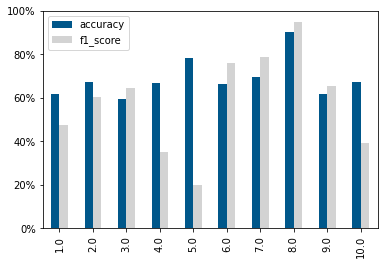

In [91]:
scores_df[['accuracy', 'f1_score']].plot(kind='bar', color=['#00578a', 'lightgrey'])
plt.xticks(ticks=np.arange(0, 10), labels=offers)
y_ticks = np.arange(0, 1.1, 0.2)
y_labels = ['{}%'.format(int(v*100)) for v in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels); 

**Results:**
* Though offer 5 has an overall accuracy of 78% the f1 score for a successful outcome is only 16%. When looking at the classification report we see why: There are far more unsuccessful labels (893) vs successful labels (225). This means a) offer 5 is a rather unsuccessful offer and b) we can predict zeros with higher reliability.
* Offer 8 ...
* Offers 6 and 7 ...
* Offers 4 and 9 ...

f1_score = 2 * (precision * recall) / (precision + recall)

***
<a id="model2"></a>
### Model 2 - Collaborative Filtering Recommendation System

For this recommendation system only user-offer interactions are of interest. The basis for setting up a collaborative filtering system is the user-item-matrix. In this case, the item is represented by the offer itself. Since I already calculated the interactions, the user-item-matrix can be derived easily.

In [179]:
# Second user group for which we don't have age, gender and income data
users2 = profile_less.person_id.values

In [251]:
# User-offer-matrix
user_offer_matrix = user_offer_df.drop(['gender', 'age', 'income', 'member_year', 'member_month', 'member_day'], axis=1)

In [252]:
user_offer_matrix = user_offer_matrix.set_index('person_id')
user_offer_matrix

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
person_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
5,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16996,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN
16997,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN
16998,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN


In [245]:
def create_train_test(df, train_size, test_size):
    ''' 
    Create a training and test dataset.
    
    INPUT:
    df - dataframe to split into train and test
    train_size - no of rows in training dataset
    test_size - no of rows in test dataset
    
    OUTPUT:
    train_df -  training dataset
    test_df - test dataset
    '''
    
    train_df = df.head(train_size)
    test_df = df.iloc[train_size:train_size+test_size]
    
    return train_df, test_df

In [247]:
train_size = int(user_offer_matrix.shape[0]*0.8)
test_size = user_offer_matrix.shape[0]-train_size

In [248]:
train_df, test_df = create_train_test(user_offer_matrix, train_size=train_size, test_size=test_size)

FunkSVD ...

In [280]:
success_matrix = np.array(user_offer_matrix)

In [281]:
def FunkSVD(success_mat=success_matrix, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization.
    
    INPUT:
    success_mat - matrix with users as rows, offers as columns, and (non-)successes as values
    latent_features - no of latent features used
    learning_rate 
    iters - no of iterations
    
    OUTPUT:
    user_mat - a user by latent feature matrix
    offer_mat - a latent feature by movie matrix
    '''
    
    n_users = success_mat.shape[0] 
    n_offers = success_mat.shape[1] 
    num_success = np.count_nonzero(~np.isnan(success_mat))
    
    # initialize the user and offer matrices with random values
    user_mat = np.random.rand(n_users, latent_features)  
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sum squared error (sse) at 0 for first iteration
    sse_accum = 0
    
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    for iteration in range(iters):
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                # if the pair exists
                if (success_mat[i, j] == 0) or (success_mat[i, j] == 1):
                    # compute the error as the actual minus the dot product of the user and offer matrices
                    error = success_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += error ** 2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += 2 * learning_rate * error * offer_mat[k, j]
                        offer_mat[k, j] += 2 * learning_rate * error * user_mat[i, k]
        
        print(iteration, sse_accum/num_success)
        
    return user_mat, offer_mat

In [282]:
# Results with 5 latent features, a learning rate of 0.01 and 100 iterations
user_mat, offer_mat = FunkSVD(success_matrix, 5, 0.01, 100)

Optimization Statistics
Iterations | Mean Squared Error 
0 0.2338506572901145
1 0.2275045559945001
2 0.22488628222552962
3 0.222318851917541
4 0.21980184329219996
5 0.21733468730352049
6 0.2149166749515028
7 0.21254696106131263
8 0.21022456805791082
9 0.20794838971239724
10 0.20571719484540926
11 0.20352963098328505
12 0.2013842279740545
13 0.19927940158279145
14 0.19721345709949273
15 0.1951845930071734
16 0.19319090477331924
17 0.1912303888438675
18 0.1893009469354693
19 0.1874003907379072
20 0.18552644715435465
21 0.18367676422128534
22 0.18184891786182084
23 0.18004041963466613
24 0.17824872564471733
25 0.17647124677902729
26 0.17470536042200943
27 0.17294842378479355
28 0.1711977889542676
29 0.1694508197262251
30 0.1677049102337224
31 0.16595750531586775
32 0.1642061224947904
33 0.16244837534114676
34 0.160681997914267
35 0.15890486986601282
36 0.15711504170320037
37 0.15531075961795832
38 0.15349048922617028
39 0.15165293750711806
40 0.14979707221989969
41 0.14792213808775753
42 

In [283]:
# Make predictions for entire dataset
pred = np.abs(np.round(np.dot(user_mat, offer_mat)))
pred

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [288]:
pred[30]

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 0.])

In [289]:
success_matrix[30]

array([ 0., nan, nan, nan, nan,  1., nan, nan,  1., nan])

In [294]:
pred.sum(axis=0) / user_offer_df.shape[0]

array([0.38317647, 0.39270588, 0.571     , 0.31888235, 0.24617647,
       0.69447059, 0.68623529, 0.86611765, 0.51494118, 0.31952941])

**Results:**
...

***

<a id="model3"></a>
### Model 3 - Ranked Based Recommendation System

For completely new users we neither have personal information nor any interactions. Therefore I will create a Ranked Based Recommendation System, i.e. recommending offers with the highest overall success rates.

In [120]:
def ranked_portfolio(df=user_offer_df, offer_type=['informational', 'bogo', 'discount']):
    """
    Rank the offers by successfulness.
    
    INPUT:
    df - user_offer_df
    offer_type - select specific offers (default all offers)
    
    OUTPUT:
    portfolio_success - df containing a list of offers and their success rate (from highest to lowest)
    """
    
    ranked_offers = (df[offers].sum() / 
                     df[offers].count()).to_frame().reset_index().rename(columns={'index': 'offer', 
                                                                                  0:'success_rate'})
    
    portfolio_successes = pd.concat([portfolio_clean, ranked_offers], axis=1).drop('offer', axis=1)
    
    portfolio_successes = portfolio_successes[portfolio_successes.offer_type.isin(offer_type)]
    
    portfolio_successes = portfolio_successes.sort_values(by=['success_rate'], ascending=False)
    
    return portfolio_successes

In [151]:
ranked_portfolio().style.bar(subset=['success_rate'], align='mid', color=['lightgrey'])

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,success_rate
7,0,0,3,informational,8,1,1,1,0,0.897785
6,2,10,10,discount,7,1,1,1,1,0.636924
5,3,7,7,discount,6,1,1,1,1,0.603953
2,0,0,4,informational,3,1,1,0,1,0.574159
8,5,5,5,bogo,9,1,1,1,1,0.499681
1,10,10,5,bogo,2,1,1,1,1,0.384834
0,10,10,7,bogo,1,1,1,1,0,0.363037
3,5,5,7,bogo,4,1,1,0,1,0.302439
9,2,10,7,discount,10,1,1,0,1,0.300875
4,5,20,10,discount,5,1,0,0,1,0.189363


In [159]:
def recommend_top_offers(offer_type=['informational', 'bogo', 'discount'], n=2, rainbow=False):
    """
    Recommend n offers to user.
    
    INPUT:
    offer_type - select specific offers (default all offers)
    n - no of recommendations (default 2)
    rainbow - if True the highest ranked offer from each type will be returned
    
    OUTPUT:
    recs - list of recommended offer ids
    """
    
    top_offers = ranked_portfolio(offer_type=offer_type)
    
    if rainbow:
        recs = []
        for offer in top_offers.offer_type.unique():
            rec = top_offers[top_offers.offer_type == offer].head(1)['offer_id'].values
            recs.extend(rec)
    else:
        if n <= len(offers):
            recs = top_offers.head(n).offer_id.values
        else:
            recs = top_offers.head(len(offers)).offer_id.values
    
    return recs

In [160]:
# Example: Recommend highest ranked offer from each offer type
recommend_top_offers(n=1, rainbow=True)

[8, 7, 9]

**Results:**
For new users we can base our recommendations on the knowledge of overall successfulness. If over 60% of users react positively about offer 6, the new user might like it too. This approach ignores the fact that a new user might fall into a sub group who prefers a lower ranked offer. The default number of recommendations is 2 (on average a user received 1.8 offers during the observation period). I added a rainbow option to the recommender. If rainbow is set to True the highest ranked offer for each offer type is returned. 

***

<a id="refine"></a>
## Model Refinement

**``Classifier Model``**

#### Different classifier
[...]

#### Additional parameters via feature engineering
[...]

In [164]:
# Source: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [166]:
for i, user in enumerate(users):
    avg_amount = transcript_clean[transcript_clean.person_id == user].amount.mean()
    user_idx = user_offer_df[user_offer_df.person_id == user].index
    user_offer_df.loc[user_idx, 'avg_amount'] = avg_amount
    update_progress(i / len(users))

Progress: [####################] 100.0%


In [167]:
for i, user in enumerate(users):
    no_offers = transcript_clean[(transcript_clean.person_id == user) & (transcript_clean.event == 'offer received')]['event'].count()
    user_idx = user_offer_df[user_offer_df.person_id == user].index
    user_offer_df.loc[user_idx, 'no_offers'] = no_offers
    update_progress(i / len(users))
    

Progress: [####################] 100.0%


In [168]:
user_offer_df['avg_amount'] = user_offer_df.avg_amount.fillna(0)

In [169]:
for offer in offers:
    df = get_offer_df(offer)
    df = get_dummies_df(df)
    clf, X_test, Y_test = classifier_model(df, offer)
    print(offer)
    evaluate_model(clf, X_test, Y_test)

1.0
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       701
           1       0.58      0.72      0.64       412

    accuracy                           0.70      1113
   macro avg       0.69      0.70      0.69      1113
weighted avg       0.72      0.70      0.70      1113


2.0
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       621
           1       0.68      0.80      0.73       482

    accuracy                           0.75      1103
   macro avg       0.75      0.75      0.75      1103
weighted avg       0.76      0.75      0.75      1103


3.0
              precision    recall  f1-score   support

           0       0.68      0.63      0.66       492
           1       0.72      0.76      0.74       613

    accuracy                           0.70      1105
   macro avg       0.70      0.70      0.70      1105
weighted avg       0.70      0.70      0.70      1105


4.0


#### GridSearch

[...]

**``Collaborative Filtering Recommendation Engine``**

**``Ranked Based Recommendation Engine``**

I won't be implementing any refinement for the third model. I will only give an outlook of what might be possible.

In [164]:
ranked_offers = ranked_portfolio(offer_type=['discount', 'bogo'])
ranked_offers

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,success_rate
6,2,10,10,discount,7,1,1,1,1,0.636924
5,3,7,7,discount,6,1,1,1,1,0.603953
8,5,5,5,bogo,9,1,1,1,1,0.499681
1,10,10,5,bogo,2,1,1,1,1,0.384834
0,10,10,7,bogo,1,1,1,1,0,0.363037
3,5,5,7,bogo,4,1,1,0,1,0.302439
9,2,10,7,discount,10,1,1,0,1,0.300875
4,5,20,10,discount,5,1,0,0,1,0.189363


There are several ways to improve the Ranked Based Recommendation System. If content-related information about each offer was available, we could combine the recommender with a Content Based Recommendation System. Offers would be clustered into similar groups based on specific characteristics. 

Another approach could be to identify influencing factors on how the offer is presented to the user. From ``portfolio_clean`` several hypothesis could be made:
* Approaching users via social media platforms has a positive effect.
* A very high upfront investment discorages users from a purchase.
* Bogos should be offered for a short time period only.

However, there are too few data points to support any of these statements.

### Putting it all together

In [ ]:
#def make_recommendation():
#no nessecity to check whether or not a user has already seen an offer
#he/she can purchase the same offer again

***

<a id="end"></a>
## Conclusion

### How to improve the results?
* The membership date actually could be used for making predictions
* Include timeline of events 
* Take into account how many offers a user already received from a specfic offer type
* Cold Start Problem: During the sign up process ask users about preferences